In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
plt.style.use('seaborn-whitegrid')

In [2]:
# read in the cleaned datasets
offers = pd.read_csv('cleaned_data/offers.csv')
customers = pd.read_csv('cleaned_data/customers.csv')
events = pd.read_csv('cleaned_data/events.csv')
print(f'offers has {len(offers)} rows')
print(f'customers has {len(customers)} rows')
print(f'events has {len(events)} rows')

offers has 10 rows
customers has 16994 rows
events has 306514 rows


# Project Ideas
## Find out active/inactive customers before the 1st offer came in
- Compare customer events before they got first offer VS after they got first offer
- Do not send offers to those who were already active
- Do not send offers to those who complete offers but don't view offers (they might not like them)

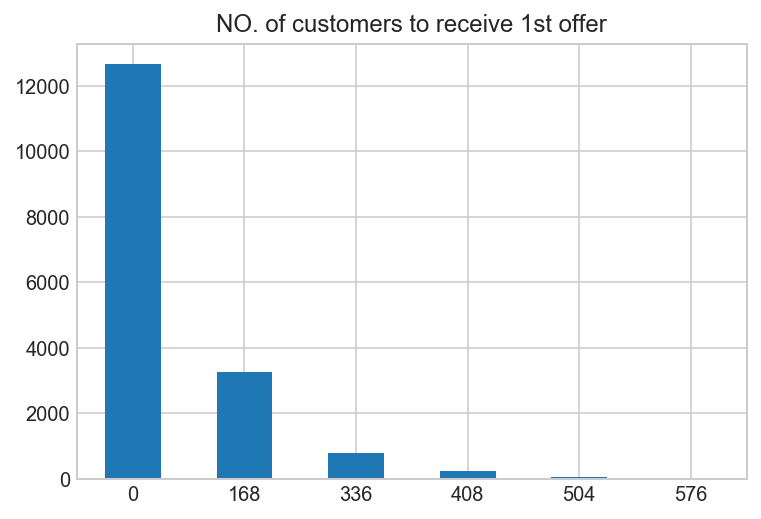

In [5]:
waves = events.query("event == 'offer received'").groupby('customer_id').hour.min().to_frame().rename({'hour':'first_offer_hour'},axis=1).reset_index()

waves.first_offer_hour.value_counts().plot(kind='bar');
plt.xticks(rotation=360); plt.title('NO. of customers to receive 1st offer');

In [24]:
def get_wave_ids(hour):
    '''
    input:
        hours - hours after start of the test to receive the first offer (0,168,336,408,504,576)
    output:
        ids - list of customer ids who got their first offers at this hour
    
    '''
    ids = list(waves[waves.first_offer_hour == hour].customer_id)
    return ids
    
time_of_waves = [0,168,336,408,504,576]

def create_pre_post_offer_events():

    '''
    input:
        None
    output:
        pre_offer_events - customer events before everyone receiving the first offer
        post_offer_events - customer events after everyone receiving the first offer
    '''

    pre_offer_events = pd.DataFrame()
    current = pd.DataFrame()

    for hour in time_of_waves:
        current = events[events.customer_id.isin(get_wave_ids(hour))]
        current = current[current.hour < hour]
        pre_offer_events = pd.concat([pre_offer_events, current])

    
    post_offer_events = pd.DataFrame()
    current = pd.DataFrame()

    for hour in time_of_waves:
        current = events[events.customer_id.isin(get_wave_ids(hour))]
        current = current[current.hour >= hour]
        post_offer_events = pd.concat([post_offer_events, current])


    # check the quality of data wrangling
    assert list(pre_offer_events.event.unique()) == ['transaction']
    assert list(post_offer_events.event.unique()) == ['offer received', 'offer viewed', 'transaction', 'offer completed']
    assert len(pre_offer_events) + len(post_offer_events) == len(events), [len(pre_offer_events) + len(post_offer_events), len(events)]

    return pre_offer_events, post_offer_events

In [15]:
pre_offer_events, post_offer_events = create_pre_post_offer_events()

### Compare the same 2595 customers events pre and post first offer
Metrics:
- average amount spent per week
- average transactions per week


In [16]:
print(f'{pre_offer_events.customer_id.nunique()} customers in pre_offer_events')
print(f'type of events: {pre_offer_events.event.unique()}')
pre_offer_events.head()

2595 customers in pre_offer_events
type of events: ['transaction']


,index,customer_id,event,hour,offer_id,amount_spent,reward_received
12659,12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13.23,NaN
12849,12849,098d124614df4e4b862d678160b98638,transaction,0,NaN,1.21,NaN
12853,12853,98b81a8ffdd14bb986d80673491171a7,transaction,0,NaN,7.40,NaN
12914,12914,ad18ad432f5a40c7b8ccce4be4fb530c,transaction,0,NaN,17.00,NaN
12994,12994,2372a5dd677842478b5318e4ea525969,transaction,0,NaN,12.88,NaN


In [18]:
pre_offer_events['day'] = (pre_offer_events.hour/24 + 1).astype(int)
pre_offer_events['week'] = (pre_offer_events.hour/24/7 + 1).astype(int)
pre_offer_events.sample(5)

,index,customer_id,event,hour,offer_id,amount_spent,reward_received,day,week
32000,32002,f34c9d5335fd42ea98695cc7e9e43be8,transaction,54,NaN,22.75,NaN,3,1
46919,46921,9da5eab04268483ca929019de255c51f,transaction,126,NaN,9.45,NaN,6,1
50855,50857,d3fde2db514a40c8bae78da030e153a9,transaction,150,NaN,22.20,NaN,7,1
21959,21960,067d163ebd2748cf954bd1ccc4cfa4af,transaction,18,NaN,27.84,NaN,1,1
76544,76547,24c6acb661704e08aa8f57c497edc663,transaction,186,NaN,1.03,NaN,8,2


In [19]:
same_group_post_events = post_offer_events[post_offer_events.customer_id.isin(pre_offer_events.customer_id)]
same_group_post_events['day'] = (same_group_post_events.hour/24 + 1).astype(int)
same_group_post_events['week'] = (same_group_post_events.hour/24/7 + 1).astype(int)
same_group_post_events.sample(5)

,index,customer_id,event,hour,offer_id,amount_spent,reward_received,day,week
283749,283766,d272e201f4e64fdbb129337e4139d812,transaction,624,NaN,3.11,NaN,27,4
118676,118685,4de618ca398b4a89aefef5ffaed7443f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,15,3
75645,75648,e3d76b6e78c542f682a6a3bb7c3d275b,offer completed,186,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,8,2
87372,87376,6c9b18ecc7054a3fa2e56d793a09f46b,transaction,222,NaN,2.92,NaN,10,2
271399,271416,b193da492dcb4b029ebade62a96eefdc,offer completed,594,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,25,4


In [20]:
assert pre_offer_events.customer_id.nunique() == same_group_post_events.customer_id.nunique()

### The offers have made the amount spent by customers very fixed and predictable

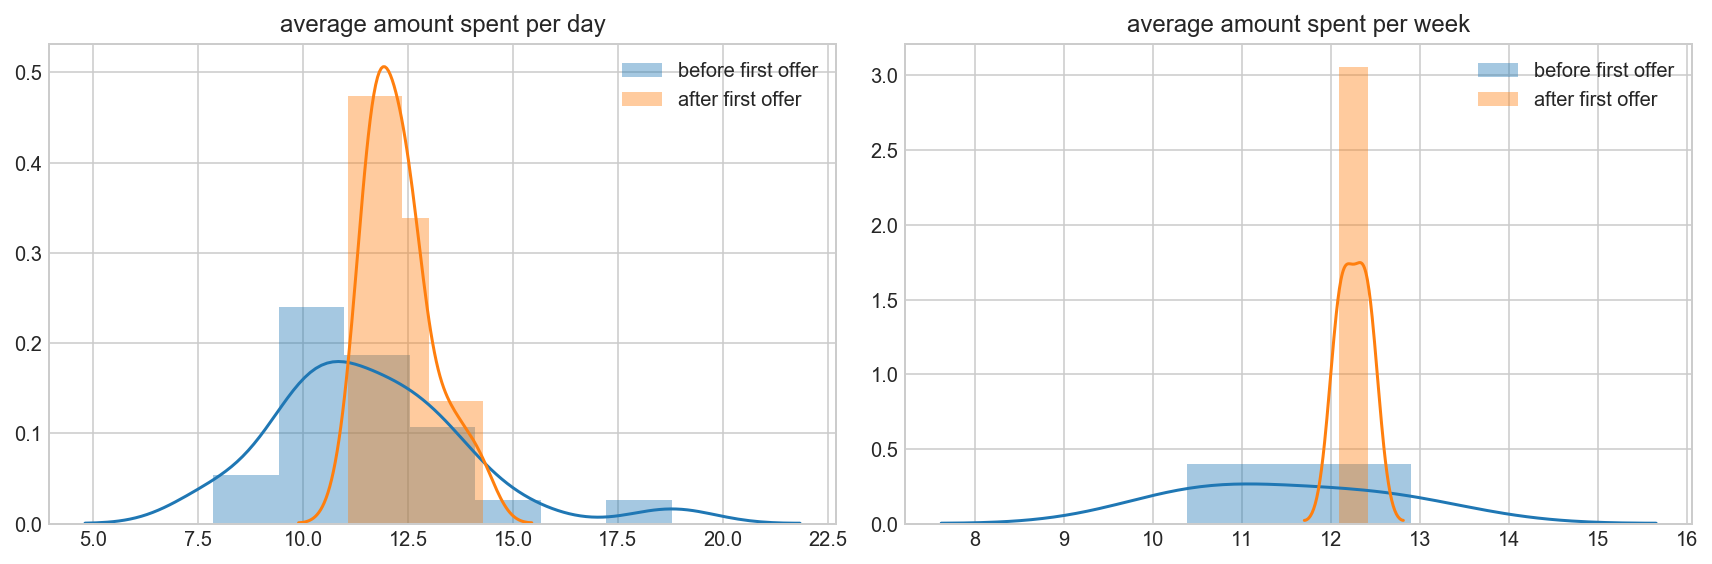

In [48]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(pre_offer_events.groupby('day').amount_spent.mean(), label='before first offer');
sns.distplot(same_group_post_events.groupby('day').amount_spent.mean(), label='after first offer');
plt.legend(); plt.xlabel(''); plt.title('average amount spent per day');

plt.subplot(1,2,2)
sns.distplot(pre_offer_events.groupby('week').amount_spent.mean(), label='before first offer');
sns.distplot(same_group_post_events.groupby('week').amount_spent.mean(), label='after first offer');
plt.legend(); plt.xlabel(''); plt.title('average amount spent per week');
plt.tight_layout()

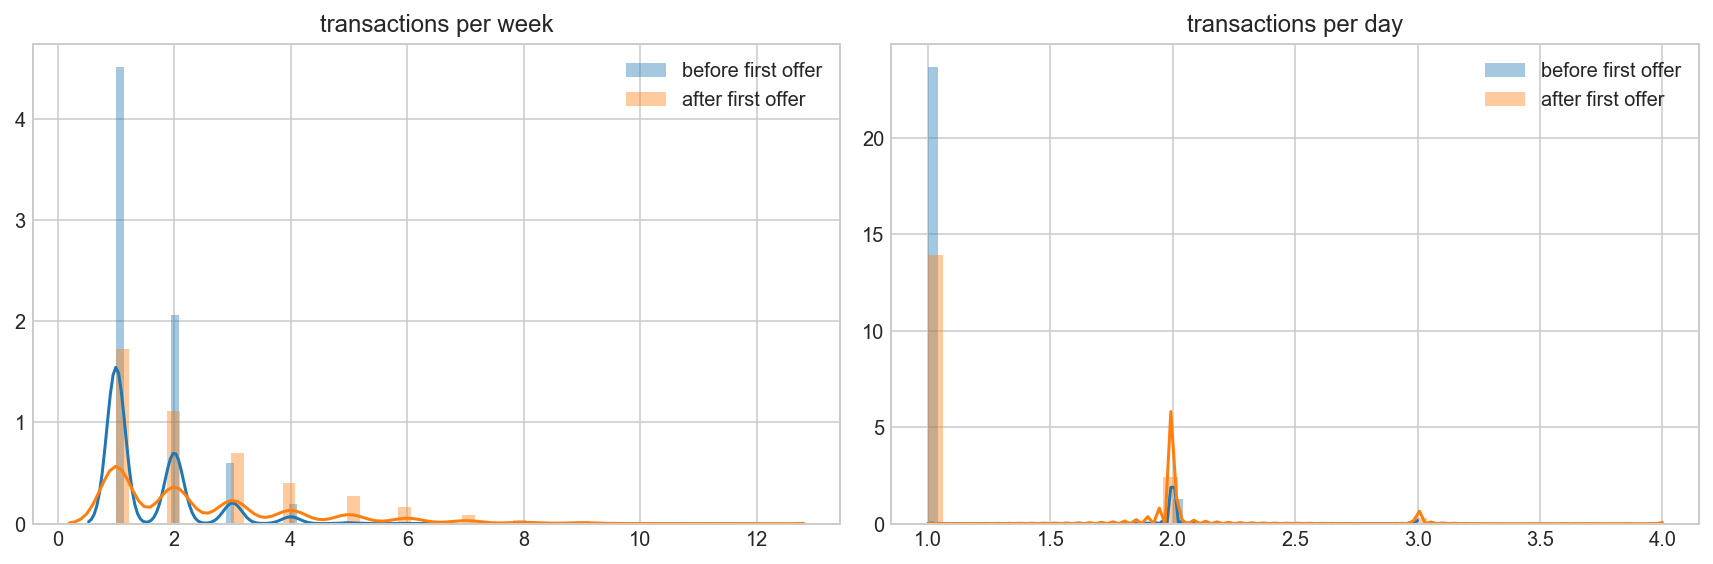

In [46]:
pre_transactions_per_week = pre_offer_events.groupby(['customer_id','week','event']).event.count()
post_transactions_per_week = same_group_post_events.query("event == 'transaction'").groupby(['customer_id','week','event']).event.count()
pre_transactions_per_day = pre_offer_events.groupby(['customer_id','day','event']).event.count()
post_transactions_per_day = same_group_post_events.query("event == 'transaction'").groupby(['customer_id','day','event']).event.count()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(pre_transactions_per_week, label='before first offer');
sns.distplot(post_transactions_per_week, label='after first offer');
plt.legend(); plt.xlabel(''); plt.title('transactions per week');

plt.subplot(1,2,2)
sns.distplot(pre_transactions_per_day, label='before first offer');
sns.distplot(post_transactions_per_day, label='after first offer');
plt.legend(); plt.xlabel(''); plt.title('transactions per day'); 
plt.tight_layout()